In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

import os
import warnings
warnings.filterwarnings("ignore")

# Traditional Trading (Berkshire Hathaway)

In [2]:
data_dir = 'data/'
super_investor = 'Warren Buffett - Berkshire Hathaway/'
# https://www.dataroma.com/m/m_activity.php?m=BRK&typ=a

df = []
directory = data_dir+super_investor

data_columns = ['Time', 'Stock', 'Order', 'Shares_Traded', 'Portfolio_Pct_Change']
data_dtypes = {'Time': 'str', 'Stock': 'str', 'Order': 'str', 'Shares_Traded': 'int', 'Portfolio_Pct_Change': 'float'}
for file_name in os.listdir(directory):

    data = pd.read_html(directory+file_name)[0]
    data.columns = data_columns
    data['Time'] = data['Time'].replace('≡', np.nan).ffill()
    df.append(data)

df = pd.concat(df, axis=0, ignore_index=True)

In [4]:
def clean_order(x):
    if 'Sell' in x or 'Reduce' in x:
        return -1
    elif 'Buy' in x or 'Add' in x:
        return 1

def clean_stock(x):
    values = x.split('-')

    symbol = values[0].strip()
    name = values[-1].strip()
    return symbol, name

df.drop_duplicates(inplace=True)
idx_drop = df.loc[df['Time'] == df['Stock']].index
df.drop(idx_drop, axis=0, inplace=True)
df = df.astype(data_dtypes)

df['Year'] = df['Time'].apply(lambda x: x.split(' ')[-1]).astype(int)
df['Quarter'] = df['Time'].apply(lambda x: x.split(' ')[0]).astype(str)
df.sort_values(by=['Year', 'Quarter'], inplace=True)
df.reset_index(drop=True, inplace=True)

df['Order_Direction'] = df['Order'].apply(clean_order)
df['Shares_Traded_Movement'] = df['Shares_Traded'] * df['Order_Direction']
df['Stock_Symbol'] = df['Stock'].apply(lambda x: clean_stock(x)[0])
df['Stock_Name'] = df['Stock'].apply(lambda x: clean_stock(x)[1])

df['Shares_Ownership'] = df.groupby('Stock_Symbol')['Shares_Traded_Movement'].cumsum()
df.loc[df['Shares_Ownership'] < 0, 'Shares_Ownership'] = 0
df['Shares_Traded_Movement'] = df.groupby('Stock_Symbol')['Shares_Ownership'].diff().fillna(0)
df['Shares_Ownership_Pct_Change'] = df.groupby('Stock_Symbol')['Shares_Ownership'].pct_change().replace(np.inf, 1)
df['Shares_Ownership_Pct_Change'] = df.groupby('Stock_Symbol')['Shares_Ownership_Pct_Change'].ffill()
nan_fill = pd.Series(np.select(
    [(df['Shares_Ownership'] == 0) & (df['Shares_Ownership_Pct_Change'].isna()),
     (df['Shares_Ownership'] > 0) & (df['Shares_Ownership_Pct_Change'].isna())],
    [0, 1]))
df.loc[df['Shares_Ownership_Pct_Change'].isna(), 'Shares_Ownership_Pct_Change'] = nan_fill.loc[df['Shares_Ownership_Pct_Change'].isna()]

yr_start, yr_end = df['Year'].iloc[0], df['Year'].iloc[-1]
qr_start, qr_end = df['Quarter'].iloc[0], df['Quarter'].iloc[-1]

if qr_start == 'Q1':
    start = f'{yr_start}-01-01'
elif qr_start == 'Q2':
    start = f'{yr_start}-04-01'
elif qr_start == 'Q3':
    start = f'{yr_start}-07-01'
elif qr_start == 'Q4':
    start = f'{yr_start}-10-01'

if qr_end == 'Q1':
    end = f'{yr_end}-03-31'
elif qr_end == 'Q2':
    end = f'{yr_end}-06-30'
elif qr_end == 'Q3':
    end = f'{yr_end}-09-30'
elif qr_end == 'Q4':
    end = f'{yr_end}-12-31'

dates_quarter_start = pd.date_range(start=start, end=end, freq='QS')
dates_quarter_end = pd.date_range(start=start, end=end, freq='QE')

dates_quarter = pd.DataFrame([(t, start, end) for t, start, end in zip(df['Time'].unique(), dates_quarter_start, dates_quarter_end)])
dates_quarter.columns = ['Time', 'Quarter_Start', 'Quarter_End']

df['Avg_Price'] = 0
for _, row in dates_quarter.iterrows():
    stocks = df.loc[df['Time'] == row['Time'], 'Stock_Symbol'].unique().tolist()
    stock_data = yf.download(stocks, start=row['Quarter_Start'], end=row['Quarter_End'], show_errors=False).loc[:, 'Adj Close'].mean(axis=0)
    for stock in stock_data.index:
        df.loc[(df['Time'] == row['Time']) & (df['Stock_Symbol'] == stock), 'Avg_Price'] = stock_data[stock]

latest_avg_prices = yf.download(df['Stock_Symbol'].unique().tolist(), start=dates_quarter['Quarter_Start'].iloc[-1], end=dates_quarter['Quarter_End'].iloc[-1], show_errors=False).loc[:, 'Adj Close'].mean(axis=0)

df['Trade_Amount'] = df['Shares_Traded_Movement'] * df['Avg_Price']
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

stocks_drop = df.groupby('Stock_Symbol').apply(lambda x: x.iloc[0]).loc[lambda x: x['Shares_Traded_Movement'] < 0].index.tolist()
idx_drop = df.loc[df['Stock_Symbol'].isin(stocks_drop)].index.tolist()
df.drop(idx_drop, axis=0, inplace=True)
df.reset_index(drop=True, inplace=True)

ownership_sum = df.groupby('Stock_Symbol')['Shares_Ownership'].sum()
idx_drop = df.loc[df['Stock_Symbol'].isin(ownership_sum[ownership_sum == 0].index)].index.tolist()
df.drop(idx_drop, axis=0, inplace=True)

ownership_change = df.groupby('Stock_Symbol')['Shares_Ownership'].diff()
idx_drop = df.loc[ownership_change[ownership_change == 0].index].index.tolist()
df.drop(idx_drop, axis=0, inplace=True)
df.reset_index(drop=True, inplace=True)

yfinance: download(show_errors=False) argument is deprecated and will be removed in future version. Do this instead to suppress error messages: logging.getLogger('yfinance').setLevel(logging.CRITICAL)
[*********************100%%**********************]  11 of 11 completed
[*********************100%%**********************]  17 of 17 completed
[*********************100%%**********************]  23 of 23 completed
[*********************100%%**********************]  11 of 11 completed
[*********************100%%**********************]  13 of 13 completed
[*********************100%%**********************]  5 of 5 completed
[*********************100%%**********************]  12 of 12 completed
[*********************100%%**********************]  14 of 14 completed
[*********************100%%**********************]  10 of 10 completed
[*********************100%%**********************]  10 of 10 completed
[*********************100%%**********************]  13 of 13 completed
[*******************

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 784 entries, 0 to 783
Data columns (total 15 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Time                         784 non-null    object 
 1   Stock                        784 non-null    object 
 2   Order                        784 non-null    object 
 3   Shares_Traded                784 non-null    int64  
 4   Portfolio_Pct_Change         784 non-null    float64
 5   Year                         784 non-null    int64  
 6   Quarter                      784 non-null    object 
 7   Order_Direction              784 non-null    int64  
 8   Shares_Traded_Movement       784 non-null    float64
 9   Stock_Symbol                 784 non-null    object 
 10  Stock_Name                   784 non-null    object 
 11  Shares_Ownership             784 non-null    int64  
 12  Shares_Ownership_Pct_Change  784 non-null    float64
 13  Avg_Price           

In [6]:
df

,Time,Stock,Order,Shares_Traded,Portfolio_Pct_Change,Year,Quarter,Order_Direction,Shares_Traded_Movement,Stock_Symbol,Stock_Name,Shares_Ownership,Shares_Ownership_Pct_Change,Avg_Price,Trade_Amount
0,Q1 2007,JNJ - Johnson & Johnson,Add 97.92%,24076800,2.52,2007,Q1,1,0.0,JNJ,Johnson & Johnson,24076800,1.000000,38.932167,0.000000e+00
1,Q1 2007,SNY - Sanofi Aventis,Add 69.60%,340000,0.02,2007,Q1,1,0.0,SNY,Sanofi Aventis,340000,1.000000,22.263472,0.000000e+00
2,Q1 2007,WFC - Wells Fargo,Add 13.83%,28222600,1.69,2007,Q1,1,0.0,WFC,Wells Fargo,28222600,1.000000,22.082816,0.000000e+00
3,Q1 2007,UNP - Union Pacific,Buy,42052400,1.86,2007,Q1,1,0.0,UNP,Union Pacific,42052400,1.000000,17.330016,0.000000e+00
4,Q1 2007,NSC - Norfolk Southern Corp.,Buy,6362800,0.56,2007,Q1,1,0.0,NSC,Norfolk Southern Corp.,6362800,1.000000,33.268148,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
779,Q4 2023,PARA - Paramount Global CL B,Reduce 32.44%,30408484,0.13,2023,Q4,-1,-30408484.0,PARA,Paramount Global CL B,63322491,-0.324423,13.294893,-4.042775e+08
780,Q4 2023,HPQ - HP Inc.,Reduce 77.71%,79666320,0.70,2023,Q4,-1,-79666320.0,HPQ,HP Inc.,22852715,-0.777088,27.560374,-2.195634e+09
781,Q4 2023,DHI - D.R. Horton,Sell 100.00%,5969714,0.20,2023,Q4,-1,-5969714.0,DHI,D.R. Horton,0,-1.000000,122.733905,-7.326863e+08
782,Q4 2023,MKL - Markel Group Inc.,Sell 100.00%,158715,0.07,2023,Q4,-1,-158715.0,MKL,Markel Group Inc.,0,-1.000000,1418.726826,-2.251732e+08


In [30]:
def get_returns(asset):
    position_prices = []
    position_share_amounts = []
    position_weights = []
    returns = []
    returns_t = []
    position_shares_total = 0
    data = df.loc[df['Stock_Symbol'] == asset]

    for _, row in data.iterrows():
        if row['Order_Direction'] == 1:

            position_prices.append(row['Avg_Price'])
            position_share_amounts.append(row['Shares_Traded'])

            position_shares_total += row['Shares_Traded']
            position_weights = [amount / position_shares_total for amount in position_share_amounts]

            avg_buy_price = np.sum(np.array(position_prices) * np.array(position_weights))

        elif row['Order_Direction'] == -1:
            if position_shares_total == 0:
                continue

            elif position_shares_total - row['Shares_Traded'] < 0:
                returns_weight = 1
                position_shares_total = 0

            else:
                returns_weight = row['Shares_Traded'] / position_shares_total
                position_shares_total -= row['Shares_Traded']

            position_share_amounts = [amount * (1 - returns_weight) for amount in position_share_amounts]

            t = dates_quarter.loc[dates_quarter['Time'] == row['Time'], 'Quarter_End'].item()
            returns_t.append(t)
            ret = ((row['Avg_Price'] / avg_buy_price) - 1) * returns_weight
            returns.append(ret)
    
    if len(returns) == 0:
        return pd.Series()

    if position_shares_total:
        t = dates_quarter.loc[dates_quarter['Time'] == data['Time'].iloc[-1], 'Quarter_End'].item()
        if returns_t[-1] == t:
            ret = ((data['Avg_Price'].iloc[-1] / avg_buy_price) - 1) + returns[-1] 
            returns[-1] = ret
        else:
            returns_t.append(t)
            ret = (data['Avg_Price'].iloc[-1] / avg_buy_price) - 1
            returns.append(ret)
    
    returns = pd.Series(returns, index=returns_t)
    return returns

def get_stats(asset, returns):

    data = df.loc[df['Stock_Symbol'] == asset]
    equity_curve = (returns + 1).cumprod() - 1

    start = returns.index[0]
    end = returns.index[-1]
    duration = end - start

    def td_format(td_object):
        seconds = int(td_object.total_seconds())
        periods = [
            ('Y', 60*60*24*365),
            ('M', 60*60*24*30),
            ('W', 60*60*24*7),
            ('D', 60*60*24),
            ('H', 60*60),
            #('Min', 60),
            #('S', 1)
        ]

        strings=[]
        for period_name, period_seconds in periods:
            if seconds >= period_seconds:
                period_value , seconds = divmod(seconds, period_seconds)
                strings.append(f'{period_value}{period_name}')

        return ' '.join(strings)

    duration_str = td_format(duration.to_pytimedelta())

    return_final = equity_curve.iloc[-1]
    returns_total = returns.sum()
    buy_hold_returns = (latest_avg_prices[asset] / data['Avg_Price'].iloc[0]) - 1

    n_trades = returns.count()
    win_rate = returns.loc[returns > 0].count() / n_trades

    best_return = returns.max()
    worst_return = returns.min()
    avg_return = returns.mean()
    volatility = returns.std() if returns.count() > 1 else 0

    avg_positive_return = returns.loc[returns > 0].mean() if returns.loc[returns > 0].count() > 0 else 0
    avg_negative_return = returns.loc[returns < 0].mean() if returns.loc[returns < 0].count() > 0 else 0

    trading_days = 252
    return_annualized = ((1 + return_final) ** trading_days) - 1 if duration.days == 0 else ((1 + return_final) ** (trading_days / duration.days)) - 1
    volatility_annualized = volatility * np.sqrt(trading_days)

    drawdown = (equity_curve / equity_curve.cummax()) - 1
    max_drawdown = drawdown.min()
    avg_drawdown = drawdown.mean()

    if returns.loc[returns < 0].count() > 0:
        profit_factor = returns.loc[returns > 0].sum() / returns.loc[returns < 0].abs().sum()
        win_loss_ratio = returns.loc[returns > 0].count() / returns.loc[returns < 0].count()
    else:
        profit_factor = returns.loc[returns > 0].sum() / 1e-2
        win_loss_ratio = returns.loc[returns > 0].count() / 1

    sharpe_ratio = (return_annualized - 0.03) / volatility_annualized if volatility_annualized != 0 else (return_annualized - 0.03) / 1e-2
    sqn_score = np.sqrt(n_trades) * avg_return / volatility if volatility != 0 else np.sqrt(n_trades) * avg_return / 1e-2
    
    stats_names = ['Asset', 'Start', 'End', 'Duration', 'Returns', 'Total Returns', 'Buy & Hold Returns', 'Number Of Trades', 
                    'Win Rate', 'Best Return', 'Worst Return', 'Avg Return', 'Avg Positive Return', 'Avg Negative Return', 'Volatility', 
                    'Returns Annual', 'Volatility Annual', 'Max Drawdown', 'Avg Drawdown', 'Profit Factor', 'Win Loss Ratio', 
                    'Sharpe Ratio', 'SQN']
    
    stats = [asset, start, end, duration_str, return_final, returns_total, buy_hold_returns, n_trades, 
                win_rate, best_return, worst_return, avg_return, avg_positive_return, avg_negative_return, volatility, 
                return_annualized, volatility_annualized, max_drawdown, avg_drawdown, profit_factor, win_loss_ratio, 
                sharpe_ratio, sqn_score]
    
    return pd.Series({k:v for k,v in zip(stats_names, stats)})

In [8]:
stats = []
returns = {}
for asset in df['Stock_Symbol'].unique():
    rets = get_returns(asset)
    rets.name = asset
    if len(rets) == 0:
        continue
    returns[asset] = rets
    stats.append(get_stats(asset, rets))

df_returns = pd.DataFrame(returns).fillna(0) # Warren Buffet's trades returns
stats = pd.DataFrame(stats) # Warren Buffet's trades stats
stats.set_index('Asset', inplace=True)

In [9]:
stats.sort_values(by='Returns', ascending=False)

,Start,End,Duration,Returns,Total Returns,Buy & Hold Returns,Number Of Trades,Win Rate,Best Return,Worst Return,...,Avg Negative Return,Volatility,Returns Annual,Volatility Annual,Max Drawdown,Avg Drawdown,Profit Factor,Win Loss Ratio,Sharpe Ratio,SQN
Asset,,,,,,,,,,,,,,,,,,,,,
MA,2011-01-01,2021-12-31,11Y 2D,24.191530,10.031755,16.701169,5,1.000000,8.897685,0.039086,...,0.000000,3.859123,0.224350,61.261678,0.000000,0.000000,1003.175484,5.00,0.003172,1.162528
MDLZ,2007-10-01,2023-09-30,16Y 3D,15.841787,5.296046,3.616027,12,0.833333,3.839884,-0.010761,...,-0.005490,1.085159,0.129516,17.226368,0.000000,0.001678,483.331985,5.00,0.005777,1.408859
PSX,2012-04-01,2020-03-31,8Y 1D,15.137182,3.428219,4.363685,11,1.000000,0.901591,0.032809,...,0.000000,0.277174,0.271164,4.399999,0.000000,0.000000,342.821901,11.00,0.054810,3.729237
CHTR,2014-04-01,2021-12-31,7Y 9M 6D,13.028335,4.779062,1.962678,12,1.000000,3.421515,0.005254,...,0.000000,0.970855,0.265028,15.411848,0.000000,0.000000,477.906206,12.00,0.015250,1.421011
V,2011-07-01,2021-12-31,10Y 6M 6D,11.635269,6.397756,11.385304,6,1.000000,5.707251,0.013922,...,0.000000,2.275117,0.181318,36.116362,0.000000,0.000000,639.775616,6.00,0.004190,1.148017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AAL,2016-07-01,2020-06-30,4Y,-0.685407,-0.683143,-0.630679,7,0.428571,0.007655,-0.686401,...,-0.174881,0.259699,-0.180950,4.122594,-42.630636,-6.272892,0.023415,0.75,-0.051169,-0.994243
PARA,2022-01-01,2023-12-31,1Y 12M 4D,-0.737157,-0.737157,-0.582973,1,0.000000,-0.737157,-0.737157,...,-0.737157,0.000000,-0.369912,0.000000,0.000000,0.000000,0.000000,0.00,-39.991196,-73.715699
LILAK,2015-07-01,2020-12-31,5Y 6M 5D,-0.750835,-0.750835,-0.811590,1,0.000000,-0.750835,-0.750835,...,-0.750835,0.000000,-0.159891,0.000000,0.000000,0.000000,0.000000,0.00,-18.989076,-75.083467


In [52]:
assets = ['AAPL', 'AMZN', 'V', 'MA', 'JNJ']
stats.loc[assets].T

Asset,AAPL,AMZN,V,MA,JNJ
Start,2016-01-01 00:00:00,2019-01-01 00:00:00,2011-07-01 00:00:00,2011-01-01 00:00:00,2007-01-01 00:00:00
End,2023-12-31 00:00:00,2023-09-30 00:00:00,2021-12-31 00:00:00,2021-12-31 00:00:00,2012-06-30 00:00:00
Duration,8Y 1D,4Y 9M 3D,10Y 6M 6D,11Y 2D,5Y 6M 2D
Returns,5.190315,0.626329,11.635269,24.19153,0.530828
Total Returns,4.158325,0.624657,6.397756,10.031755,0.451404
Buy & Hold Returns,7.120528,0.684487,11.385304,16.701169,2.891784
Number Of Trades,6,3,6,5,6
Win Rate,1.0,1.0,1.0,1.0,0.833333
Best Return,3.91462,0.621973,5.707251,8.897685,0.169204
Worst Return,0.001434,0.00111,0.013922,0.039086,-0.01286


<Axes: title={'center': 'Equity Curve Berkshire Hathaway Holdings'}>

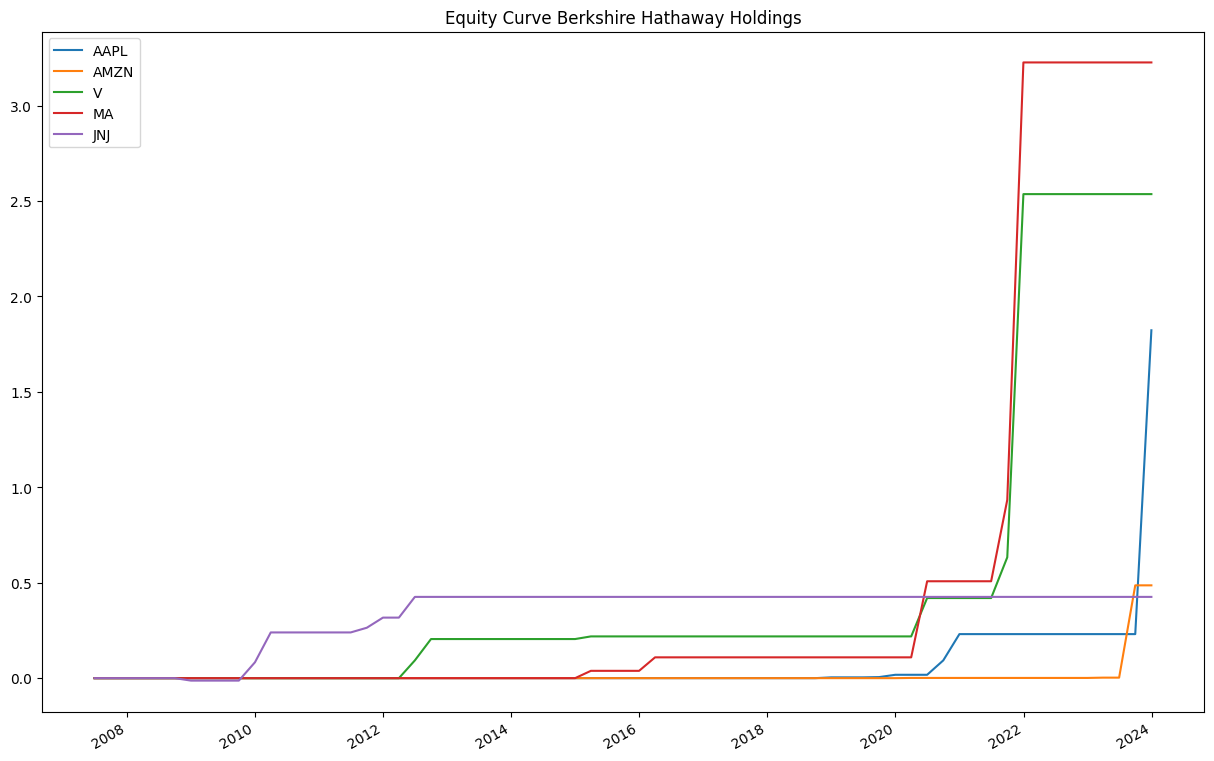

In [11]:
((df_returns[assets] + 1).cumprod().apply(np.log)).plot(figsize=(15, 10), title='Equity Curve Berkshire Hathaway Holdings')

# Algorithmic Trading (Williams Alligator)

In [12]:
dfs = {}
for asset in stats.index:
    
    data = yf.download(asset, start='2000-01-01', end='2024-01-01', show_errors=False)
    dfs[asset] = data

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [26]:
def williams_alligator_strategy(df, period_lips = 5, period_teeth = 8, period_jaw = 13, period_trend = 100, period_atr = 14, tp_multiplier = 2.0, sl_multiplier = 1.0):

    import talib as ta

    df['lips'] = df['Close'].rolling(period_lips).mean()
    df['teeth'] = df['Close'].rolling(period_teeth).mean()
    df['jaw'] = df['Close'].rolling(period_jaw).mean()
    df['trend'] = df['Close'].rolling(period_trend).mean()

    df['buy_signals'] = np.where((df['lips'] > df['teeth'])\
                               & (df['lips'] > df['jaw'])\
                               & (df['teeth'] > df['jaw'])\
                               & (df['Close'] > df['trend']),
                               1, 0)
    
    df['take_profit'] = df['Close'] + (tp_multiplier * ta.ATR(df['High'], df['Low'], df['Close'], timeperiod=period_atr))
    df['stop_loss'] = df['Close'] - (sl_multiplier * ta.ATR(df['High'], df['Low'], df['Close'], timeperiod=period_atr))

    return df

def backtest_strategy(asset, *args):

    df = dfs[asset].copy()
    df = williams_alligator_strategy(df, *args)
    start = stats.loc[asset, 'Start'].strftime('%Y-%m-%d')
    end = stats.loc[asset, 'End'].strftime('%Y-%m-%d')
    df = df.loc[start:end]
    
    in_trade = False
    returns = []
    returns_t = []

    for idx, row in df.iterrows():
        if not in_trade:
            if row['buy_signals'] == 1:
                in_trade = True
                entry_price = row['Close']
                take_profit = row['take_profit']
                stop_loss = row['stop_loss']
        else:
            if row['High'] >= take_profit:
                in_trade = False
                exit_price = row['High']
                returns_t.append(idx)
                ret = (exit_price / entry_price) - 1
                returns.append(ret)
            elif row['Low'] <= stop_loss:
                in_trade = False
                exit_price = row['Low']
                returns_t.append(idx)
                ret = (exit_price / entry_price) - 1
                returns.append(ret)
            else:
                continue
    
    returns = pd.Series(returns, index=returns_t)
    return returns

def optimize_strategy(asset, objective, space, func=backtest_strategy):

    from skopt import gbrt_minimize

    def objective_fn(params):
        if params[0] >= params[1] or params[1] >= params[2]:
            return 1e6
        returns_opt = func(asset, *params)
        if len(returns_opt) == 0:
            return 1e6
        stats_opt = get_stats(asset, returns_opt)
        return -stats_opt[objective]
    
    opt = gbrt_minimize(objective_fn, space, n_calls=300, random_state=0)

    returns = func(asset, *opt.x)
    if len(returns) == 0:
        return pd.Series(), pd.Series()
    stats = get_stats(asset, returns)
    stats['Optimal_Params'] = opt.x

    return stats, returns

In [15]:
from skopt.space import Real, Integer

objective = 'Profit Factor'
space = [
        Integer(2, 20, name='period_lips'),
        Integer(5, 50, name='period_teeth'),
        Integer(10, 100, name='period_jaw'),
        Integer(100, 200, name='period_trend'),
        Integer(10, 20, name='period_atr'),
        Real(1.0, 30.0, name='tp_multiplier'),
        Real(1.0, 30.0, name='sl_multiplier')
    ]

stats_opt = []
returns_opt = {}
for asset in stats.index:
    st, ret = optimize_strategy(asset, objective, space)
    if len(st) == 0:
        continue
    stats_opt.append(st)
    returns_opt[asset] = ret

df_returns_opt = pd.DataFrame(returns_opt).fillna(0) # William Alligator Strategy returns
stats_opt = pd.DataFrame(stats_opt) # William Alligator Strategy stats
stats_opt.set_index('Asset', inplace=True)

In [56]:
stats_opt.loc[assets].T.to_csv('trad.csv')

<Axes: title={'center': 'Equity Curves Williams Alligator Strategy'}>

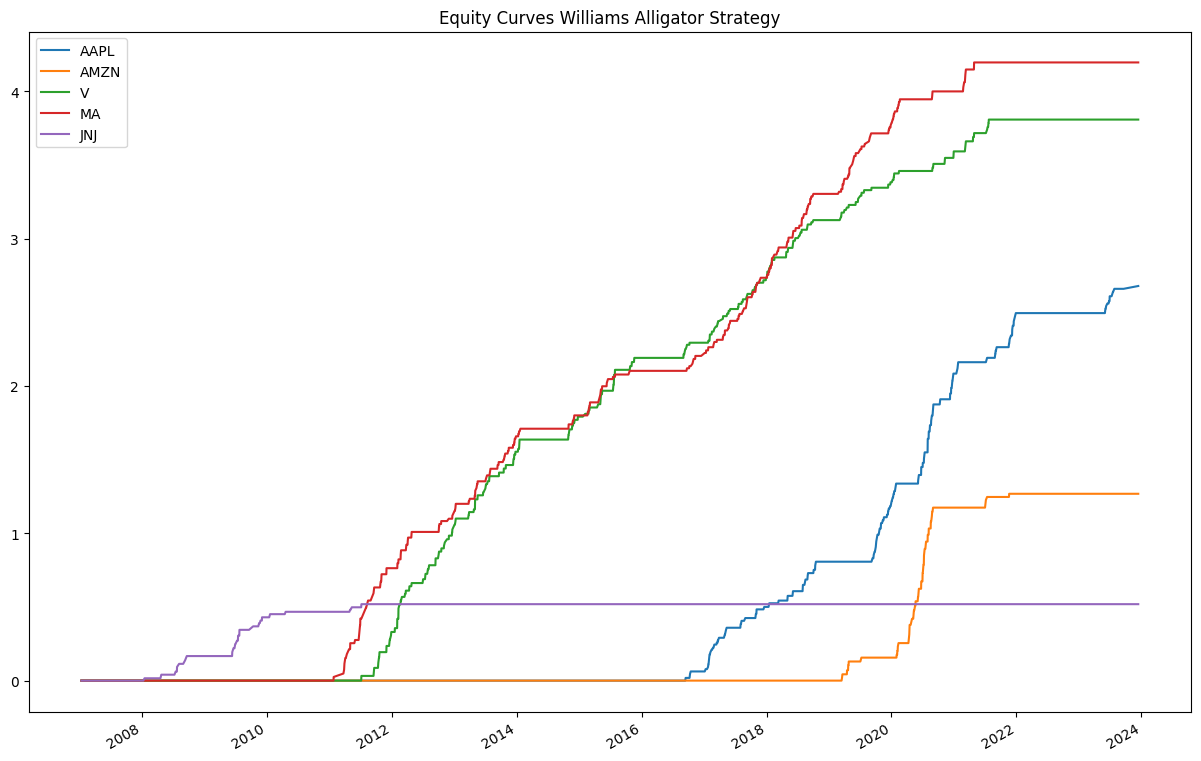

In [17]:
((df_returns_opt[assets] + 1).cumprod().apply(np.log)).plot(figsize=(15, 10), title='Equity Curves Williams Alligator Strategy')

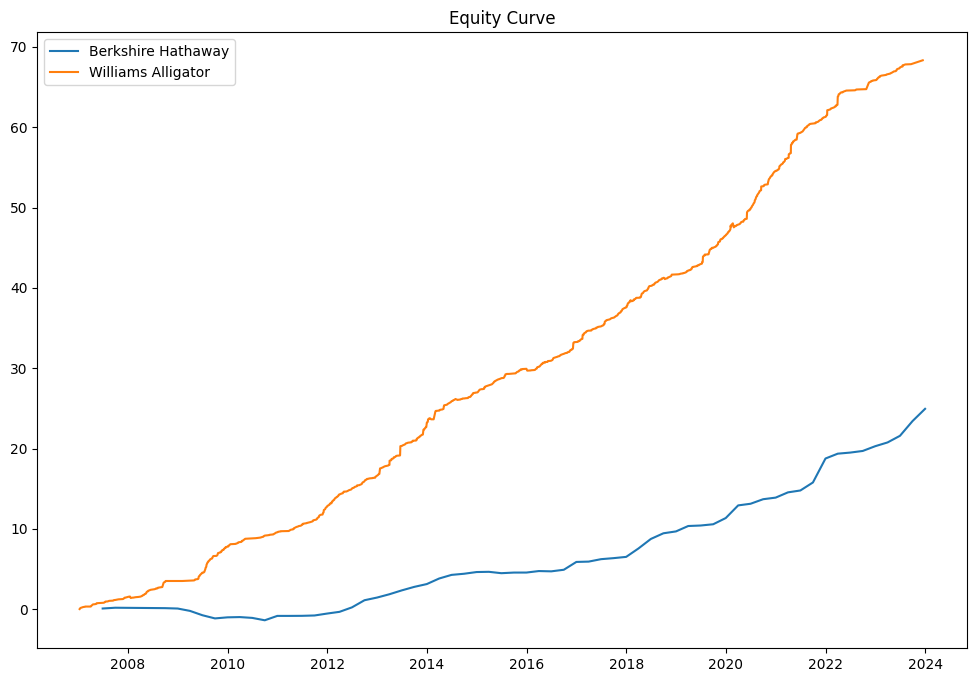

In [18]:
assets = [asset for asset in stats[stats['Returns'] > -0.5].index.tolist() if asset in stats_opt.index.tolist()]
berkshire_hatway_equity = (df_returns[assets].sum(axis=1) + 1).cumprod().apply(np.log)
williams_alligator_equity = (df_returns_opt[assets].sum(axis=1) + 1).cumprod().apply(np.log)

plt.figure(figsize=(12, 8))
plt.plot(berkshire_hatway_equity.index, berkshire_hatway_equity, label='Berkshire Hathaway')
plt.plot(williams_alligator_equity.index, williams_alligator_equity, label='Williams Alligator')
plt.title('Equity Curve')
plt.legend()

# Hybrid Trading (Berkshire Hathaway + Williams Alligator)

In [38]:
df_hybrid = df.loc[df['Stock_Symbol'].isin(assets)].copy()
df_hybrid['pct_allocation'] = df['Shares_Ownership']/df.groupby('Stock_Symbol')['Shares_Ownership'].cummax()

dates_quarter_hybrid = dates_quarter.copy()
dates_quarter_hybrid = pd.concat([dates_quarter_hybrid, pd.DataFrame(index=dates_quarter_hybrid.index, columns=assets)], axis=1)

for t in dates_quarter_hybrid['Time']:
    df_quarter = df_hybrid.loc[df_hybrid['Time'] == t]
    for asset in df_quarter['Stock_Symbol']:
        pct = df_quarter.loc[df_quarter['Stock_Symbol'] == asset, 'pct_allocation'].item()
        if pct < 0.5:
            pct = 0.5
        dates_quarter_hybrid.loc[dates_quarter_hybrid['Time'] == t, asset] = pct
dates_quarter_hybrid.ffill(inplace=True)

In [40]:
def backtest_strategy_hybrid(asset, *args):

    df = dfs[asset].copy()
    df = williams_alligator_strategy(df, *args)
    df_dates = dates_quarter_hybrid[['Quarter_Start', 'Quarter_End', asset]].dropna()
    start = df_dates['Quarter_Start'].iloc[0].strftime('%Y-%m-%d')
    df = df.loc[start:]
    
    in_trade = False
    returns = []
    returns_t = []

    for idx, row in df.iterrows():
        if not in_trade:
            if row['buy_signals'] == 1:
                in_trade = True
                entry_price = row['Close']
                take_profit = row['take_profit']
                stop_loss = row['stop_loss']
        else:
            ret_multiplier = df_dates.loc[(df_dates['Quarter_Start'] <= idx) & (df_dates['Quarter_End'] >= idx), asset].item()
            if row['High'] >= take_profit:
                in_trade = False
                exit_price = row['High']
                returns_t.append(idx)
                ret = ((exit_price / entry_price) - 1) * ret_multiplier
                returns.append(ret)
            elif row['Low'] <= stop_loss:
                in_trade = False
                exit_price = row['Low']
                returns_t.append(idx)
                ret = ((exit_price / entry_price) - 1) * ret_multiplier
                returns.append(ret)
            else:
                continue
    
    returns = pd.Series(returns, index=returns_t)
    return returns

In [41]:
objective = 'Profit Factor'
space = [
        Integer(2, 20, name='period_lips'),
        Integer(5, 50, name='period_teeth'),
        Integer(10, 100, name='period_jaw'),
        Integer(100, 200, name='period_trend'),
        Integer(10, 20, name='period_atr'),
        Real(1.0, 30.0, name='tp_multiplier'),
        Real(1.0, 30.0, name='sl_multiplier')
    ]

stats_opt_hybrid = []
returns_opt_hybrid = {}
for asset in assets:
    st, ret = optimize_strategy(asset, objective, space, backtest_strategy_hybrid)
    if len(st) == 0:
        continue
    stats_opt_hybrid.append(st)
    returns_opt_hybrid[asset] = ret

df_returns_opt_hybrid = pd.DataFrame(returns_opt_hybrid).fillna(0) # Hybrid Strategy returns
stats_opt_hybrid = pd.DataFrame(stats_opt_hybrid) # Hybrid Strategy stats
stats_opt_hybrid.set_index('Asset', inplace=True)

In [42]:
stats_opt_hybrid.loc[['AAPL', 'AMZN', 'V', 'MA', 'JNJ']].T

Asset,AAPL,AMZN,V,MA,JNJ
Start,2016-03-30 00:00:00,2019-03-18 00:00:00,2011-09-20 00:00:00,2011-01-25 00:00:00,2007-11-28 00:00:00
End,2023-07-27 00:00:00,2021-11-19 00:00:00,2023-12-12 00:00:00,2023-12-22 00:00:00,2022-04-19 00:00:00
Duration,7Y 4M,2Y 8M 1W,12Y 2M 3W 5D,12Y 11M 4D,14Y 4M 3W 5D
Returns,10.161058,2.560033,20.245685,60.525395,1.429829
Total Returns,2.457305,1.297719,3.094417,4.180305,0.893443
Buy & Hold Returns,7.120528,0.684487,11.385304,16.701169,2.891784
Number Of Trades,76,33,152,173,81
Win Rate,1.0,1.0,1.0,1.0,1.0
Best Return,0.090148,0.065944,0.073531,0.103862,0.030702
Worst Return,0.014824,0.018848,0.009256,0.010664,0.005515


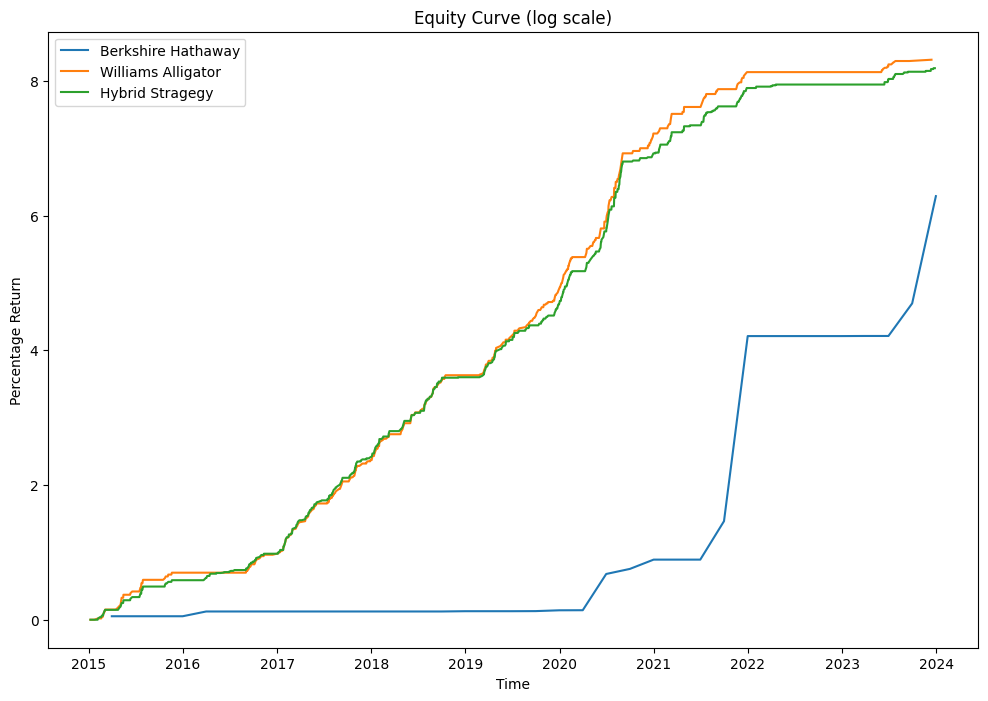

In [91]:
start_equity_dt = '2015-01-01'
berkshire_hatway_equity = (df_returns.loc[start_equity_dt:, assets].sum(axis=1) + 1).cumprod().apply(np.log)
williams_alligator_equity = (df_returns_opt.loc[start_equity_dt:, assets].sum(axis=1) + 1).cumprod().apply(np.log)
hybrid_equity = (df_returns_opt_hybrid.loc[start_equity_dt:, assets].sum(axis=1) + 1).cumprod().apply(np.log)

plt.figure(figsize=(12, 8))
plt.plot(berkshire_hatway_equity.index, berkshire_hatway_equity, label='Berkshire Hathaway')
plt.plot(williams_alligator_equity.index, williams_alligator_equity, label='Williams Alligator')
plt.plot(hybrid_equity.index, hybrid_equity, label='Hybrid Stragegy')
plt.title('Equity Curve (log scale)')
plt.xlabel('Time')
plt.ylabel('Percentage Return')
plt.legend()